# EPFL network - Battery growth over the years 

In [1]:
import json
import pickle
import collections
from collections import defaultdict
from BuildGraphModule import *
from UniformData import *
from MultiGraph import *
from AnalysisModule import *
import locale
from functools import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('paper.json', 'r') as f:
    data = json.load(f)

In [3]:
# Uniform strings - Authors
data = uniform_authors(data)

In [4]:
# Uniform strings - EPFL Authors
data = uniform_epfl_authors(data)

In [5]:
data_cut = {}
for paper in list(data.keys()):
    try:
        if int(data[paper]['Publication date']) >= 1993:
            data_cut[paper] = data[paper]
    except:
        continue

In [6]:
# For the purpose of battery graphs I used full data
data_cut = data
dict_lab_site, dict_labs, dict_labs_paper = lab_dictionaries(data_cut)

In [7]:
# Get the list of paper lab and year. Dictionary (lab, dict(year, list of papers))
dict_lab_years_pub = {}#defaultdict(list)
for lab in dict_labs_paper:
    dict_lab_years_pub[lab] = defaultdict(list)
    for pub in dict_labs_paper[lab]:
        try:
            dict_lab_years_pub[lab][data_cut[pub]['Publication date']] += [pub]
        except:
            continue

In [8]:
# Dictionary (year, total number of papers)
year_papers = defaultdict(list)
for lab in list(dict_lab_years_pub.keys()):
    for year in list(dict_lab_years_pub[lab].keys()):
        year_papers[year] += dict_lab_years_pub[lab][year]
for year in list(year_papers.keys()):
    year_papers[year] = len(set(year_papers[year]))

In [9]:
# Get dictionary (lab, dict(year,num of pubblication))
dict_author_year = {}
#dict_author_num_year = {}
for lab in dict_lab_years_pub:
    dict_author_year[lab] = defaultdict(list)
    for year in list(dict_lab_years_pub[lab].keys()):
        try:
            dict_author_year[lab][year] += [list(a.keys()) for p in dict_lab_years_pub[lab][year] for a in data_cut[p]['Epfl authors']]
        except:
            dict_author_year[lab][year] += []
            continue
    for year in list(dict_lab_years_pub[lab].keys()):
        list_authors = [i[0] for i in dict_author_year[lab][year]]
        dict_author_year[lab][year] = len(set(list_authors))

In [10]:
# Dictionary (year, number of authors)
year_authors = defaultdict(int)
for lab in list(dict_author_year.keys()):
    for year in list(dict_author_year[lab].keys()):
        year_authors[year] += dict_author_year[lab][year]

In [11]:
# Get the dictionary (lab, dict(year, number of papers))
dict_lab_years = defaultdict(list)
for lab in dict_labs_paper:
    for pub in dict_labs_paper[lab]:
        try:
            dict_lab_years[lab] += [data_cut[pub]['Publication date']]
        except:
            continue
    dict_lab_years[lab] = collections.Counter(dict_lab_years[lab])
    #dict_lab_years[lab]['Total'] = sum(list(dict_lab_years[lab].values()))

In [12]:
list_schools = ['ENAC', 'SB', 'IC', 'STI', 'SV']
dict_school_pub = {}
dict_school_authors = {}

In [13]:
# Dictionary (School, dict(year, number of publication))
for school in list_schools:
    sc_labs = school_lab(dict_lab_site, school)
    dict_school_pub = school_publication(sc_labs, school, dict_lab_years, dict_school_pub)

In [14]:
# Dictionary (School, dict(year, number of authors))
for school in list_schools:
    sc_labs = school_lab(dict_lab_site, school)
    dict_school_authors = school_author(sc_labs, school, dict_author_year, dict_school_authors)

In [15]:
cumulative_school_productivity = {}
for school in list_schools:
    cumulative_school_productivity[school] = 0
    for year in list(dict_school_pub[school].keys()):
        if year == '0':
            continue
        try:
            cumulative_school_productivity[school] += dict_school_pub[school][year]
        except:
            continue

cumulative_school_productivity_per_decade = {}
for school in list_schools:
    cumulative_school_productivity_per_decade[school] = {}
    for year in list(dict_school_pub[school].keys()):
        chunk = int(int(year) / 10)
        if year == '0':
            continue
        try:
            try:
                cumulative_school_productivity_per_decade[school][chunk] += dict_school_pub[school][year]
            except:
                cumulative_school_productivity_per_decade[school][chunk] = dict_school_pub[school][year]
        except:
            continue
    for key, value in sorted(cumulative_school_productivity_per_decade[school].items()):
        try:
            cumulative_school_productivity_per_decade[school][key] += cumulative_school_productivity_per_decade[school][key - 1]
        except:
            continue
    for chunk in cumulative_school_productivity_per_decade[school].keys():
        cumulative_school_productivity_per_decade[school][chunk] /= cumulative_school_productivity[school]

In [16]:
def show_images_horizontally(list_of_files, title):
    fig = plt.figure(figsize=(15,10))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a = fig.add_subplot(1, number_of_files, i + 1)
        image = plt.imread(list_of_files[i][0])
        plt.title(school + ',' + str(list_of_files[i][1]) + ' - ' + str(list_of_files[i][2]))
        plt.imshow(image,cmap='Greys_r')
        plt.axis('off')

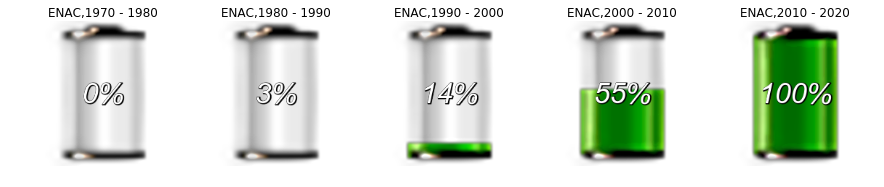

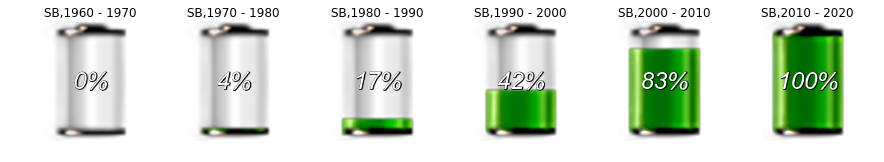

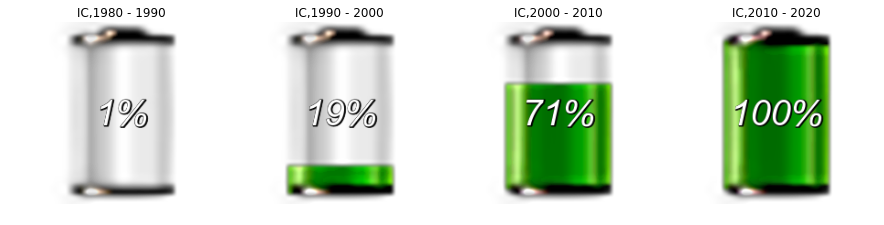

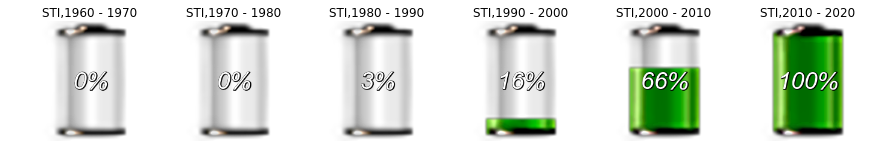

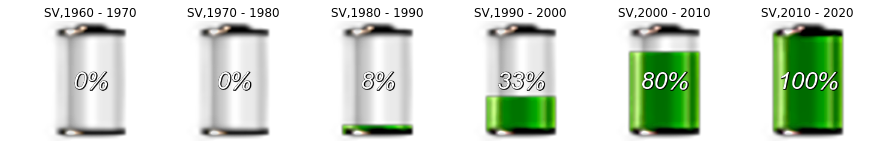

In [17]:
for school in list_schools:
    list_of_batteries = []
    for chunk, value in sorted(cumulative_school_productivity_per_decade[school].items()):
        list_of_batteries += [(int(value * 100), chunk * 10, chunk * 10 + 10)]
    list_of_batteries = list(map(lambda x: ('graviz/batteries/battery_' + str(x[0]) + '.png', x[1], x[2]), sorted(list_of_batteries)))
    show_images_horizontally(list_of_batteries, school)